In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


In [2]:
df = pd.read_csv("/kaggle/input/playground-series-s5e1/train.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [4]:
df['date'].unique()

array(['2010-01-01', '2010-01-02', '2010-01-03', ..., '2016-12-29',
       '2016-12-30', '2016-12-31'], dtype=object)

In [5]:
df

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0


In [6]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()

df['date'] = oe.fit_transform(df[['date']])
df['country'] = oe.fit_transform(df[['country']])
df['store'] = oe.fit_transform(df[['store']])
df['product'] = oe.fit_transform(df[['product']])

In [7]:
df

,id,date,country,store,product,num_sold
0,0,0.0,0.0,0.0,0.0,NaN
1,1,0.0,0.0,0.0,1.0,973.0
2,2,0.0,0.0,0.0,2.0,906.0
3,3,0.0,0.0,0.0,3.0,423.0
4,4,0.0,0.0,0.0,4.0,491.0
...,...,...,...,...,...,...
230125,230125,2556.0,5.0,1.0,0.0,466.0
230126,230126,2556.0,5.0,1.0,1.0,2907.0
230127,230127,2556.0,5.0,1.0,2.0,2299.0
230128,230128,2556.0,5.0,1.0,3.0,1242.0


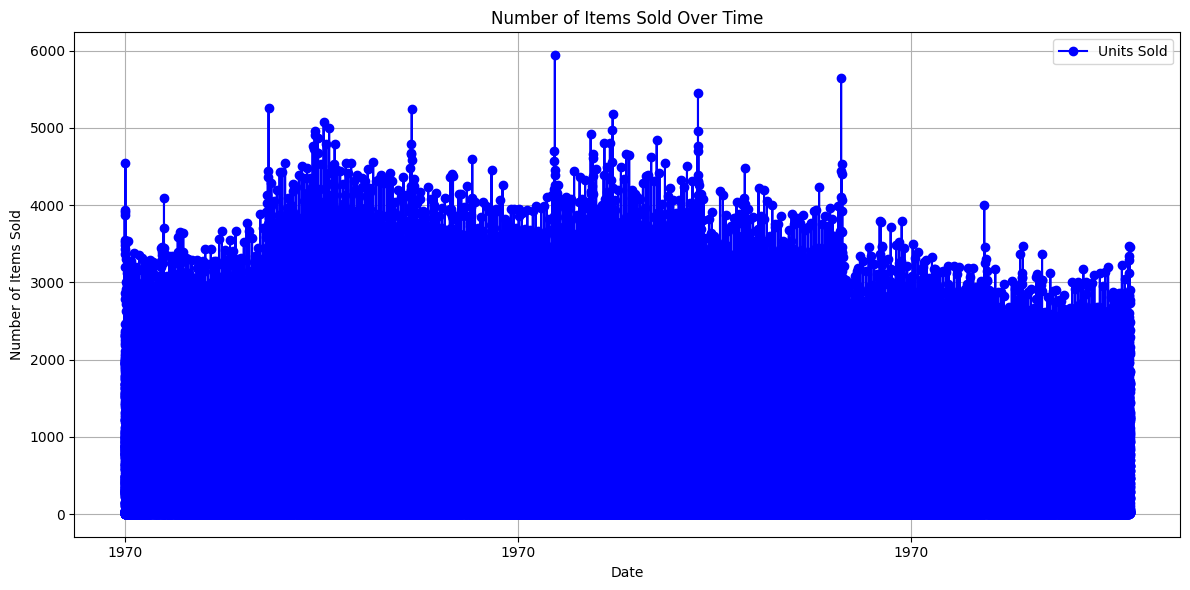

In [8]:
df['date'] = pd.to_datetime(df['date'])

# Sort the DataFrame by date (optional, but recommended for time-series visualization)
df = df.sort_values('date')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['num_sold'], marker='o', linestyle='-', color='b', label='Units Sold')
plt.xlabel('Date')
plt.ylabel('Number of Items Sold')
plt.title('Number of Items Sold Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()